In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

In [2]:
# initial parameters
epochs = 100
lr = 1e-3
batch_size = 64
img_dims = (96,96,3)

data = []
labels = []

In [8]:
# load image files from the dataset
image_files = [f for f in glob.glob(r'D:\Linkedin_Projects\Gender_Detection\gender_dataset_face' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [12]:
data = []
labels = []

for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (img_dims[0], img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2] 
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label]) # [[1], [0], [0], ...]

In [13]:

# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [14]:

# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)

trainY = to_categorical(trainY, num_classes=2) # [[1, 0], [0, 1], [0, 1], ...]
testY = to_categorical(testY, num_classes=2)

In [15]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [16]:

# define model
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1
    
    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first", 
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

In [17]:

# build model
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=2)


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [19]:


# compile the model
opt = Adam(learning_rate=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


In [21]:
# train the model
H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)

Epoch 1/100


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.6742 - loss: 0.9613 - val_accuracy: 0.4848 - val_loss: 0.9782
Epoch 2/100
 1/28 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7500 - loss: 0.6364

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.7500 - loss: 0.6364 - val_accuracy: 0.4848 - val_loss: 0.9920
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8165 - loss: 0.4891 - val_accuracy: 0.6147 - val_loss: 0.7237
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.8281 - loss: 0.3945 - val_accuracy: 0.5628 - val_loss: 0.7363
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8274 - loss: 0.4190 - val_accuracy: 0.4848 - val_loss: 0.8357
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9531 - loss: 0.2245 - val_accuracy: 0.4848 - val_loss: 0.8469
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8569 - loss: 0.3619 - val_accuracy: 0.5195 - val_loss: 0.9254
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.8906 - loss: 0.2807 - val_accuracy: 0.5238 - val_loss: 0.9223
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8526 - loss: 0.3754 - val_accuracy: 0.5173 - val_los

In [23]:
# save the model to disk
model.save('gender_detection.keras')

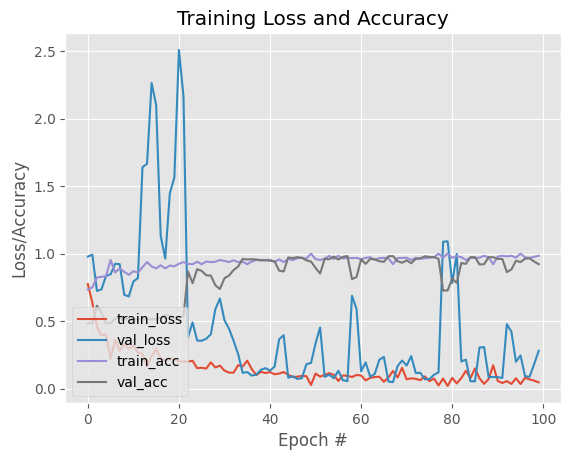

In [25]:
# Plot training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")  # Use "accuracy" instead of "acc"
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")  # Use "val_accuracy" instead of "val_acc"
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [26]:

# save plot to disk
plt.savefig('plot.png')

<Figure size 640x480 with 0 Axes>